<a href="https://colab.research.google.com/github/anjali88/Data-Science/blob/master/MA_ARMA_ARIMA_FBProphet_Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

# Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.
# The input to Prophet is always a dataframe with two columns: ds and y. 
# The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. 
# The y column must be numeric, and represents the measurement we wish to forecast.

from fbprophet import Prophet

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving GS.xlsx to GS.xlsx


In [0]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
import io
data = pd.read_excel(io.BytesIO(uploaded['GS.xlsx']), index_col="Date",parse_dates=True)

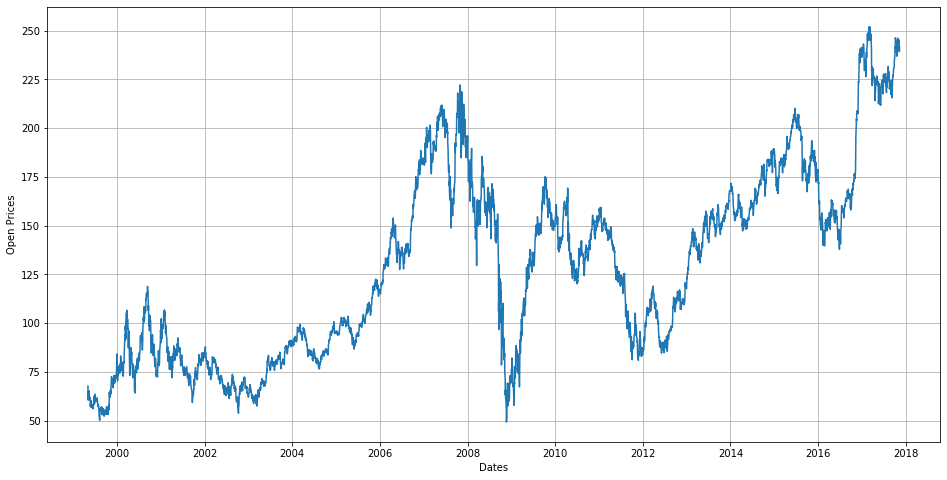

In [4]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

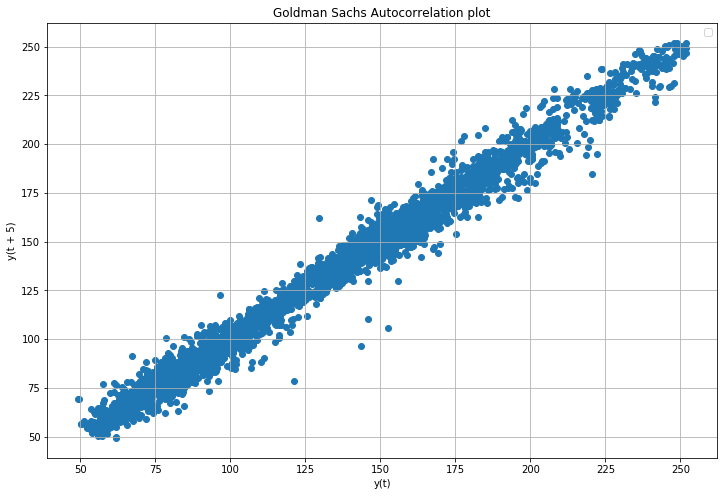

In [5]:
# Data Analysis

#Autocorrelation plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=5)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();



<Figure size 1152x576 with 0 Axes>

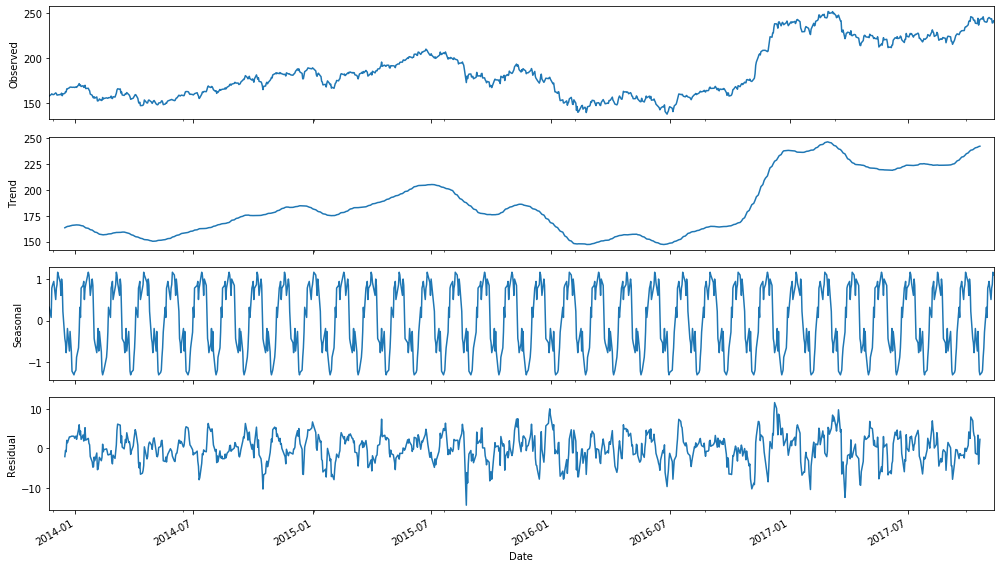

In [6]:
#Seasonal decompose

rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
result = seasonal_decompose(data_arima[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [7]:
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.994216  0.988282  0.956678  0.998288
t+1   0.994216  1.000000  0.992890  0.963463  0.992929
t+5   0.988282  0.992890  1.000000  0.971829  0.987001
t+10  0.956678  0.963463  0.971829  1.000000  0.954921
t+30  0.998288  0.992929  0.987001  0.954921  1.000000


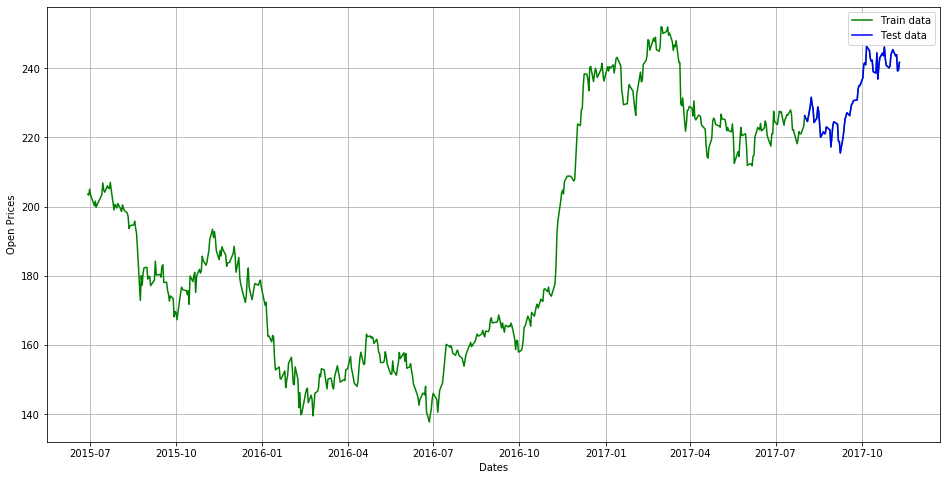

In [8]:
# Train-Test Split
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()




MSE: 10830.046294143684
MAE: 103.67446296726271
RMSE: 104.06750834983839


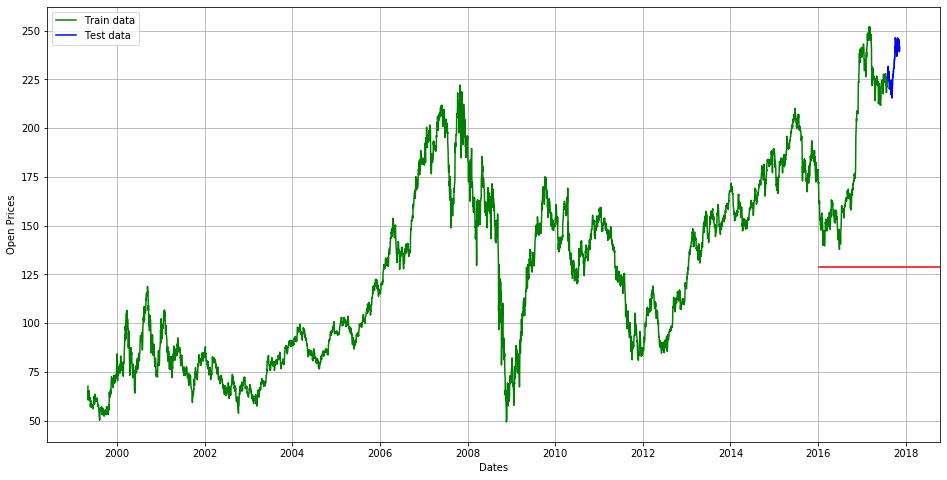

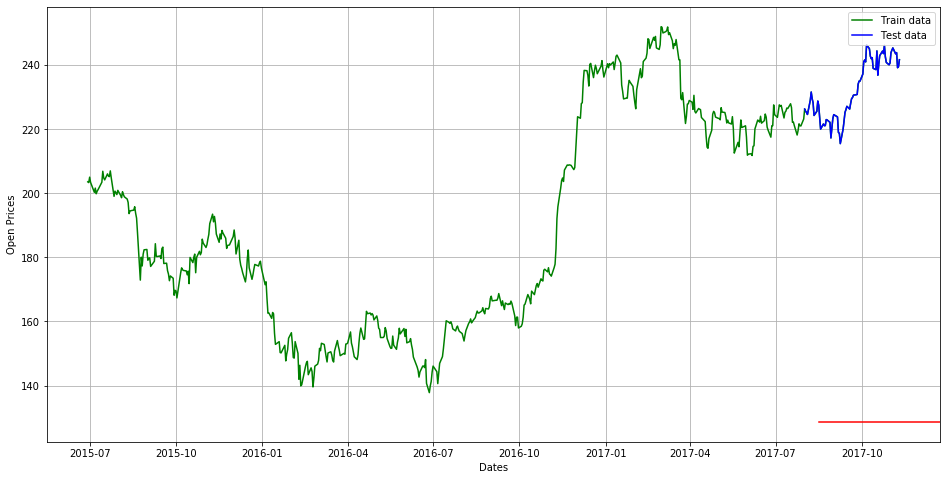

In [9]:
# Mean value plot
mean_value = data['Open'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value)))))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Lag: 31
MSE: 6.585071455492791
MAE: 2.0203155723972355
RMSE: 2.5661394068703265


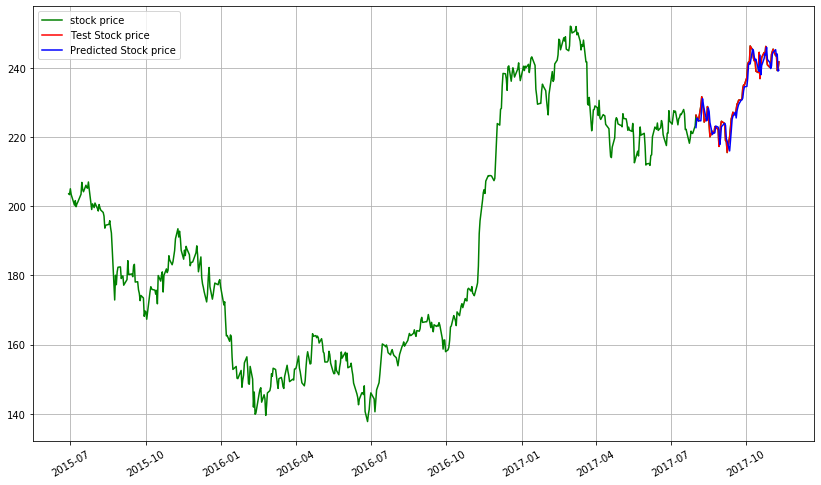

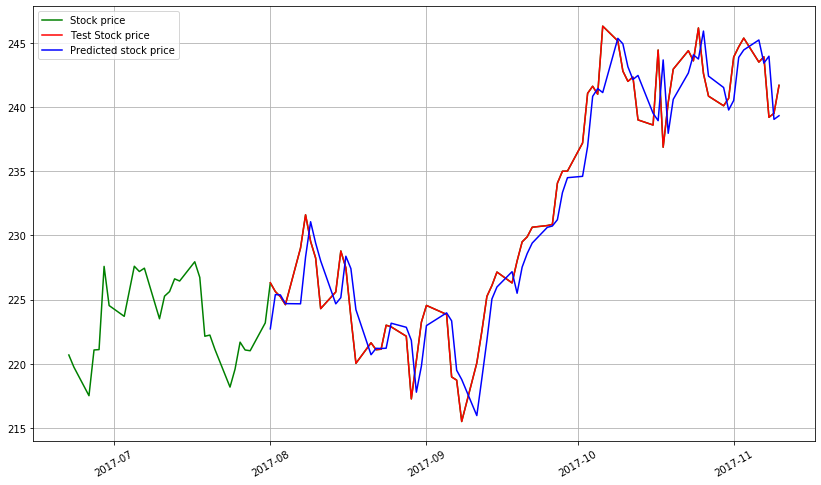

In [10]:
# Autoregression model
train_ar = train_data['Open']
test_ar = test_data['Open']

model = AR(train_ar)# train autoregression
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='stock price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Stock price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Stock price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Stock price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted stock price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Open'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], predictions))))

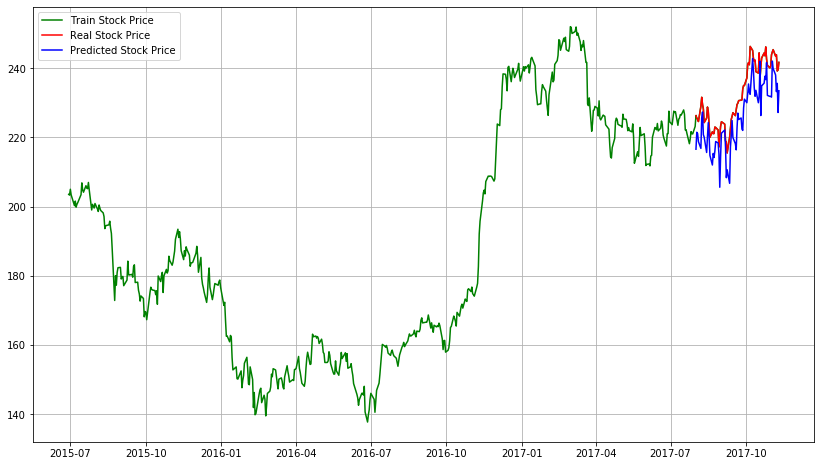

MSE: 59.36588024615888
MAE: 6.923999867030449
RMSE: 7.704925713214819


In [11]:
# Moving Average model
train_ma = train_data['Open']
test_ma = test_data['Open']

history = [x for x in train_ma]
y = test_ma
# make first prediction
predictions = list()
model = ARMA(history, order=(0,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(0,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

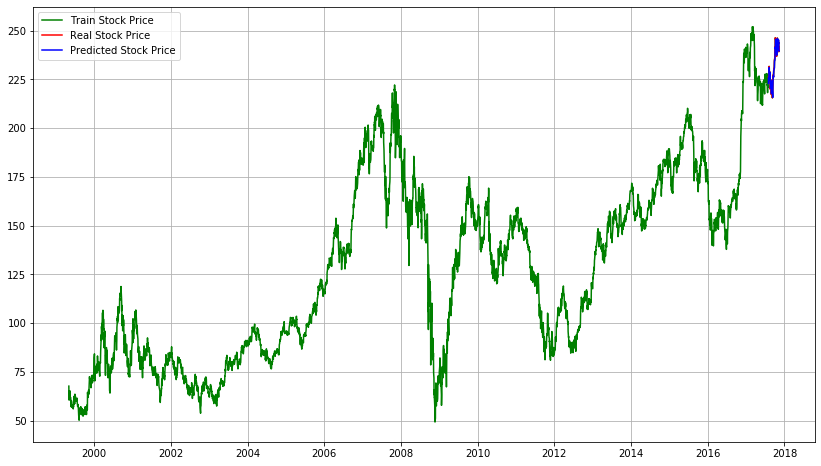

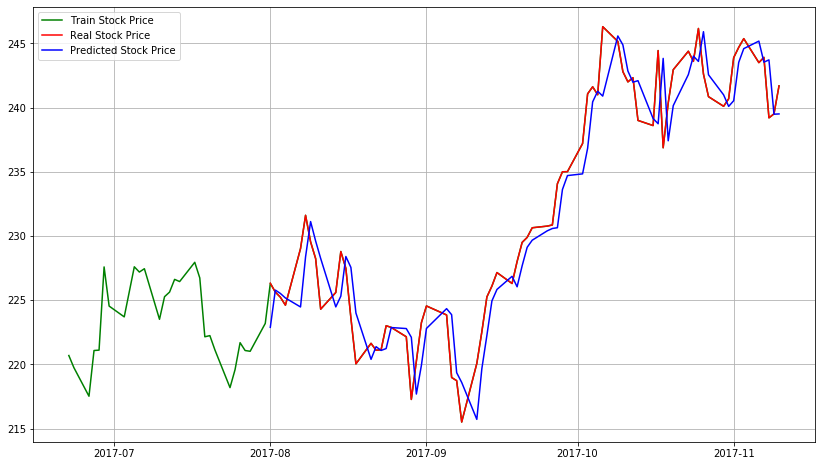

MSE: 6.677045320364875
MAE: 2.016518003129875
RMSE: 2.583997933506309


In [12]:
# ARMA model
train_arma = train_data['Open']
test_arma = test_data['Open']

history = [x for x in train_arma]
y = test_arma
# make first prediction
predictions = list()
model = ARMA(history, order=(1,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(1,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

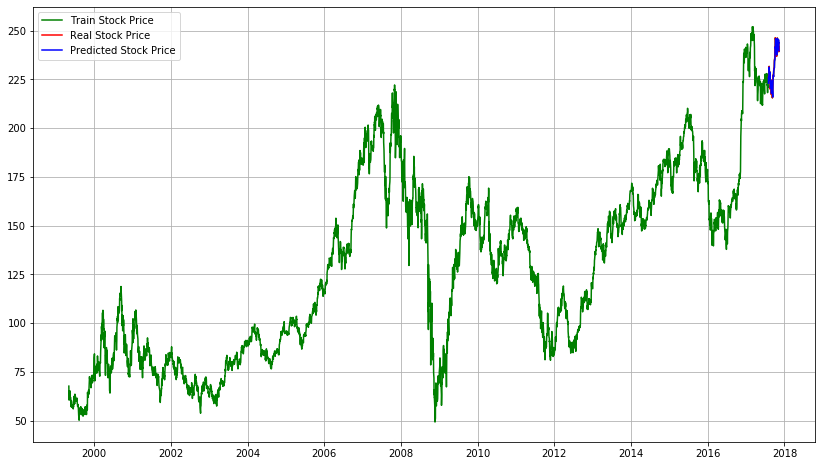

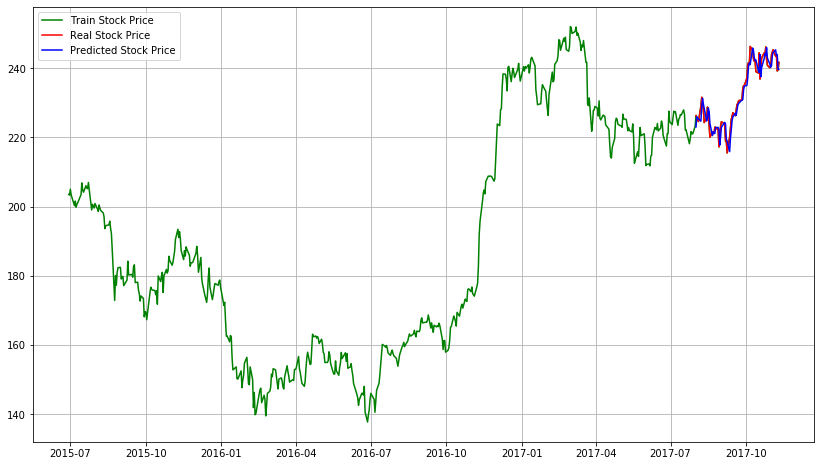

MSE: 6.585688141513062
MAE: 2.004152038329677
RMSE: 2.566259562381222


In [0]:
# ARIMA model
train_arima = train_data['Open']
test_arima = test_data['Open']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
  # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [0]:
# Facebook Prophet

# Drop the columns
ph_df_train = train_data.drop(['Close', 'High', 'Low','Volume', 'OpenInt'], axis=1)
ph_df_train['Date'] = ph_df_train.index
ph_df_train.rename(columns={'Open': 'y', 'Date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


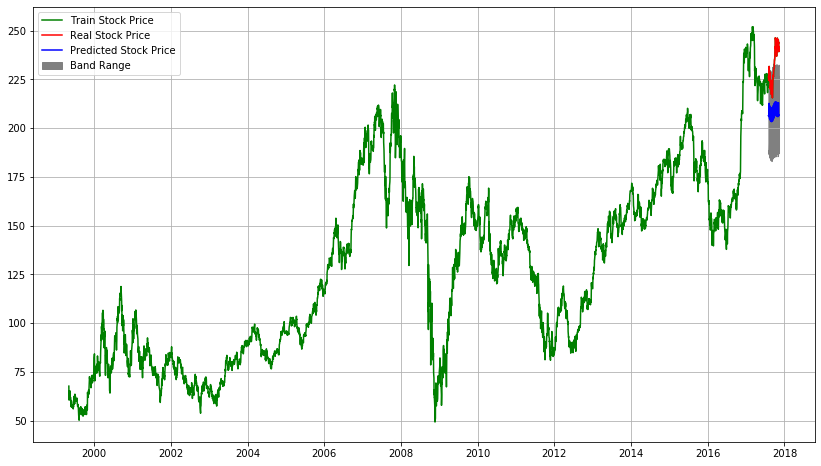

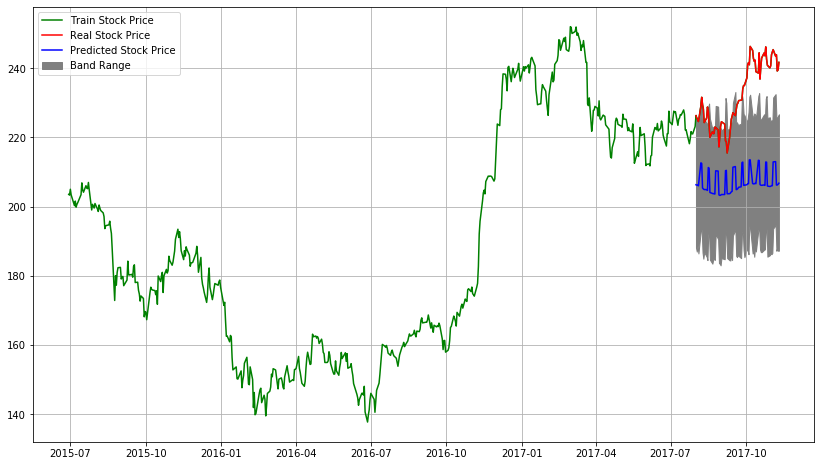

MSE: 699.5725694538435
MAE: 25.058554914045025
RMSE: 26.449434199125008


In [0]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(test_data['Open'], forecast['yhat'][-73:])))
print('MAE: '+str(mean_absolute_error(test_data['Open'], forecast['yhat'][-73:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], forecast['yhat'][-73:]))))

In [0]:
# LSTM

train = train_data.iloc[:, 0:1].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [0]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 65, batch_size = 16)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









Epoch 1/65


4581/4581 [==============================] - 6s 1ms/step - loss: 0.0080
Epoch 2/65
4581/4581 [==============================] - 4s 881us/step - loss: 0.0025
Epoch 3/65
4581/4581 [==============================] - 4s 822us/step - loss: 0.0019
Epoch 4/65
4581/4581 [==============================] - 4s 881us/step - loss: 0.0019
Epoch 5/65
4581/4581 [==============================] - 4s 809us/step - loss: 0.0016
Epoch 6/65
4581/4581 [==============================] - 4s 849us/step - loss: 0.0015
Epoch 7/65
4581/4581 [==============================] - 4s 875us/step - loss: 0.0014
Epoch 8/65
4581/4581 [==============================] - 4s 862us/step - loss: 0.0013
Epoch 9/65
4581/4581 [==============================] - 4s 840us/step - loss: 0.0012
Epoch 10/65
4581/4581 [==============================] - 4s 852us/step - loss: 0.0011
Epoch 11/65
4581/4581 [==============================] - 4s 855us/step - loss: 0.0011
Epoch 12/65
4581/4581 [==============================] - 4s 825us/step - los

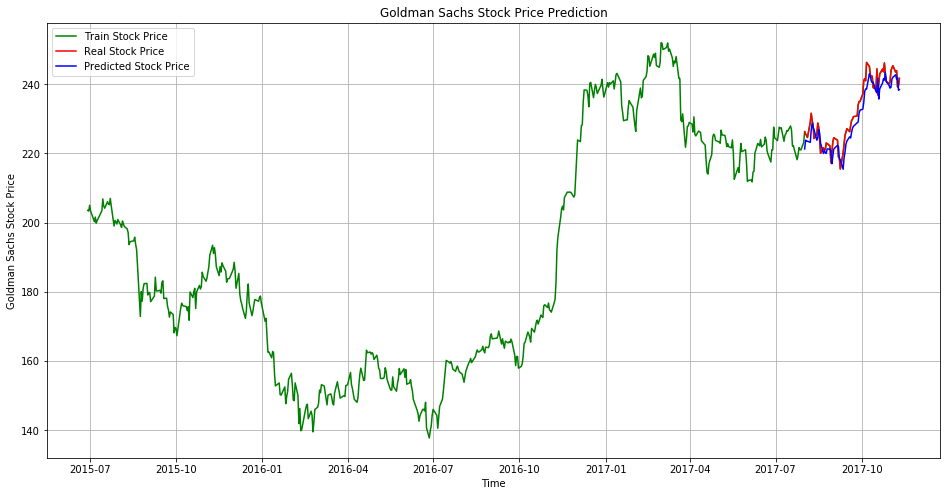

MSE: 10.629914764354842
MAE: 2.7960554316272455
RMSE: 3.26035500587817


In [0]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))